In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import transforms
from tqdm import tqdm

import dnnlib
from calibration.ece import ECE
from calibration.ReliabilityDiagram import ReliabilityDiagram
from data.classes import CIFAR10_CLASSES
from ema_pytorch import EMA
from training.diffusion import GaussianDiffusion


In [5]:
c = dnnlib.EasyDict()
c.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c.test_kwargs = dnnlib.EasyDict(
    test_dir="data/cifar10/test",
    run_dir="training-runs/00021-run",
)

c.model_kwargs = dnnlib.EasyDict(
    class_name="training.networks.EBMUNet",
    img_resolution=32,
    in_channels=3,
    model_channels=192,
    out_channels=10,
    label_dim=10,
    num_res_blocks=3,
    attn_resolutions=(2, 4),
    dropout_rate=0.0,
    channel_mult=(1, 2, 2),
    conv_resample=True,
    dims=2,
    use_checkpoint=False,
    num_heads=4,
    num_head_channels=64,
    num_heads_upsample=-1,
    use_scale_shift_norm=False,
    resblock_updown=False,
    use_new_attention_order=True,
    context_dim=512,
    use_spatial_transformer=True,
    transformer_depth=1,
    pool="sattn",
)
diffusion = GaussianDiffusion(schedule_name="cosine", timesteps=1000)
net = dnnlib.util.construct_class_by_name(**c.model_kwargs)
net = EMA(net).to(c.device).requires_grad_(False)

latest_ckpt = os.path.join(
    c.test_kwargs.run_dir,
    sorted([f for f in os.listdir(c.test_kwargs.run_dir) if f.endswith(".pt")])[-1],
)

print("Loading model from", latest_ckpt)
ckpt = torch.load(latest_ckpt, map_location=c.device, weights_only=True)
net.load_state_dict(ckpt["ema"])

c.dataset_kwargs = dnnlib.EasyDict(
    class_name="training.dataset.ImageFolderDataset",
    path=c.test_kwargs.test_dir,
    use_labels=True,
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3),
        ]
    ),
)
dataset_obj = dnnlib.util.construct_class_by_name(**c.dataset_kwargs)

c.dataloader_kwargs = dnnlib.EasyDict(
    class_name="torch.utils.data.DataLoader",
    dataset=dataset_obj,
    batch_size=128,
    num_workers=4,
    pin_memory=True,
    shuffle=False,
)
test_dataloader = dnnlib.util.construct_class_by_name(**c.dataloader_kwargs)

Loading model from training-runs/00021-run/model-000110.pt


In [ ]:
# shape = (16, 3, 32, 32)
# samples = diffusion.sample(net, shape, y, guidance_scale=6.0)

def classifier_cond_fn(x, t, classifier, y, classifier_scale=1):
    """
    return the graident of the classifier outputing y wrt x.
    formally expressed as d_log(classifier(x, t)) / dx
    """
    assert y is not None
    
        
num_images = 16
img_size, img_channels = dataset_obj.resolution, dataset_obj.num_channels
samples = torch.randn((num_images, img_channels, img_size, img_size), device=c.device)

net.eval()
for t in reversed(range(0, diffusion.num_timesteps)):
    timesteps = torch.full((num_images,), t, device=c.device, dtype=torch.long)
    y = torch.randint(low=0, high=10, size=(num_images,))

    with torch.enable_grad():
        x_in = x.detach().requires_grad_(True)
        logits = classifier(x_in, t)
        log_probs = F.log_softmax(logits, dim=-1)
        selected = log_probs[range(len(logits)), y.view(-1)]
        grad = torch.autograd.grad(selected.sum(), x_in)[0] * classifier_scale
        return grad
    
    with torch.no_grad():
        pred_noise = net(samples, timesteps)
        samples = diffusion.p_sample(pred_noise, samples, timesteps)


In [ ]:
from torchvision.utils import make_grid
samples = make_grid(samples, nrow=4, normalize=True, scale_each=True)

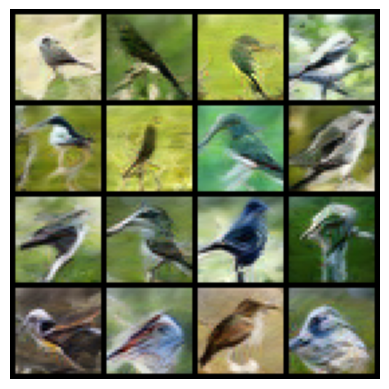

In [17]:
plt.imshow(samples)
plt.axis("off")
plt.show()

In [ ]:
def evaluate(net, dataloader, device, return_outputs=False):
    """Evaluate the model on the given dataset.

    :param net: The model to evaluate
    :param dataloader: The DataLoader object to use for evaluation
    :param device: The device to use for evaluation
    :param return_outputs: Whether to return the outputs or not

    :return: Tuple of (loss, accuracy, ece) or (loss, accuracy, ece, gts, confs, preds)
    """

    loss_total, correct_total, samples_total = 0, 0, 0
    ece_total = 0

    gts_all, confs_all, preds_all = [], [], []

    ce_loss = torch.nn.CrossEntropyLoss(reduction="sum")
    ece_loss = ECE()

    net.eval()

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating", leave=False):
            images, labels = images.to(device), labels.to(device)
            batch_size = images.size(0)
            samples_total += batch_size

            clean_timesteps = torch.zeros(batch_size, dtype=torch.long, device=device)
            logits = net(images, clean_timesteps, cls_mode=True)

            labels = labels.argmax(dim=1)
            loss = ce_loss(logits, labels)
            loss_total += loss.item()

            probs = torch.nn.functional.softmax(logits, dim=1)
            conf, pred = probs.max(dim=1)

            conf_one_hot = torch.zeros_like(probs).scatter_(
                1, pred.unsqueeze(1), conf.unsqueeze(1)
            )

            correct_total += (pred == labels).sum().item()
            ece_total += ece_loss.measure(probs.cpu().numpy(), labels.cpu().numpy())

            if return_outputs:
                gts_all.append(labels.cpu())
                confs_all.append(conf_one_hot.cpu())
                preds_all.append(pred.cpu())

    loss_avg = loss_total / samples_total
    acc_acg = correct_total / samples_total
    ece_avg = ece_total / len(dataloader)

    if return_outputs:
        return (
            loss_avg,
            acc_acg,
            ece_avg,
            np.concatenate(gts_all),
            np.concatenate(confs_all),
            np.concatenate(preds_all),
        )
    return loss_avg, acc_acg, ece_avg

In [ ]:
test_loss, test_acc, test_ece, gts, confs, preds = evaluate(
    net,
    test_dataloader,
    c.device,
    return_outputs=True,
)

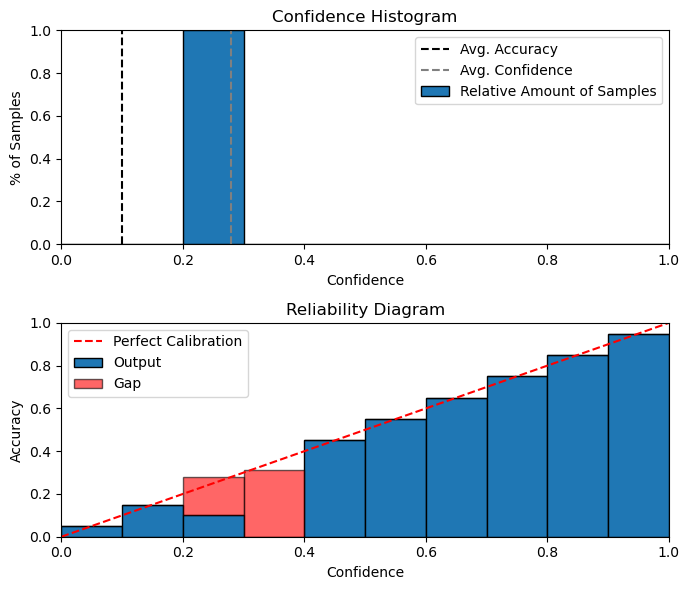

In [ ]:
diagram = ReliabilityDiagram()
diagram.plot(confs, gts)
plt.show()

In [ ]:
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test ECE: {test_ece:.4f}")

Test Loss: 2.5834
Test Accuracy: 0.1000
Test ECE: 0.1794


In [ ]:
images, labels = [], []
for i, (image, label) in enumerate(test_dataloader):
    images.append(image)
    labels.append(label)

images = torch.cat(images)
labels = torch.cat(labels).argmax(dim=1).cpu().numpy()

In [ ]:
def plot_samples(
    images: torch.Tensor,
    gts: np.ndarray,
    confs: np.ndarray,
    preds: np.ndarray,
    num_samples: int = 16,
):
    """Plot random samples from the dataset with predictions and confidences.

    :param images: Tensor of shape (N, C, H, W) containing images.
    :param gts: Tensor of shape (N,) containing ground truth labels.
    :param confs: Tensor of shape (N, C) containing confidences.
    :param preds: Tensor of shape (N,) containing predicted labels.
    :param num_samples: Number of samples to plot. Default is 16.
    """

    # Randomly choose num_sample indices from images, gts, preds, and confs
    indices = np.random.choice(len(images), num_samples, replace=False)

    images = images[indices]
    gts = gts[indices]
    preds = preds[indices]
    confs = confs[indices].max(axis=1)

    num_images = len(images)
    num_cols = 4
    num_rows = (num_images + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10), dpi=150)
    axes = axes.flatten()

    for i in range(num_images):
        ax = axes[i]
        img = images[i].permute(1, 2, 0).numpy() * 0.5 + 0.5
        img = np.clip(img, 0, 1)

        pred_name = CIFAR10_CLASSES[preds[i]]
        true_name = CIFAR10_CLASSES[gts[i]]

        # Add color to title based on correctness
        color = "green" if preds[i] == gts[i] else "red"

        ax.imshow(img)
        ax.set_title(
            f"Pred: {pred_name}\nTrue: {true_name}\nConf: {confs[i]:.2f}",
            color=color,
        )
        ax.axis("off")

    for i in range(num_images, len(axes)):
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

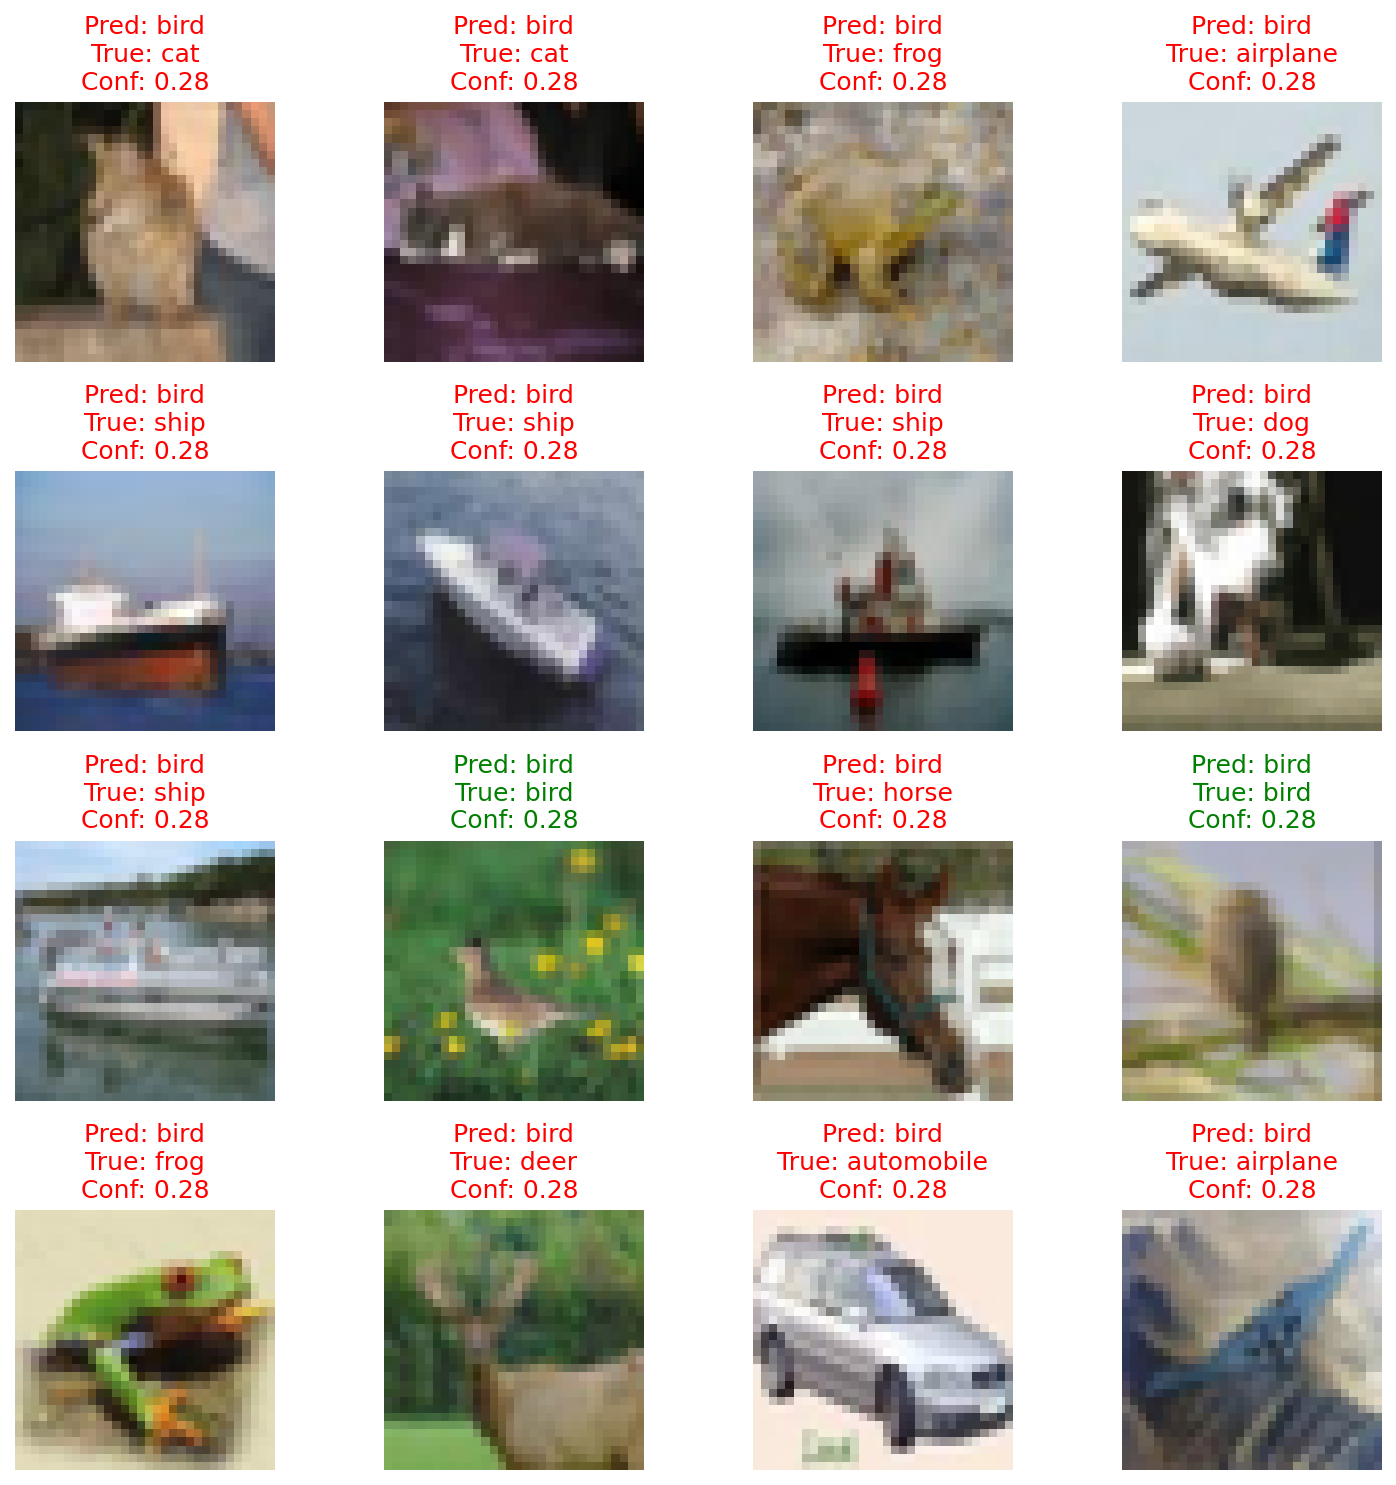

In [ ]:
plot_samples(images, labels, confs, preds)

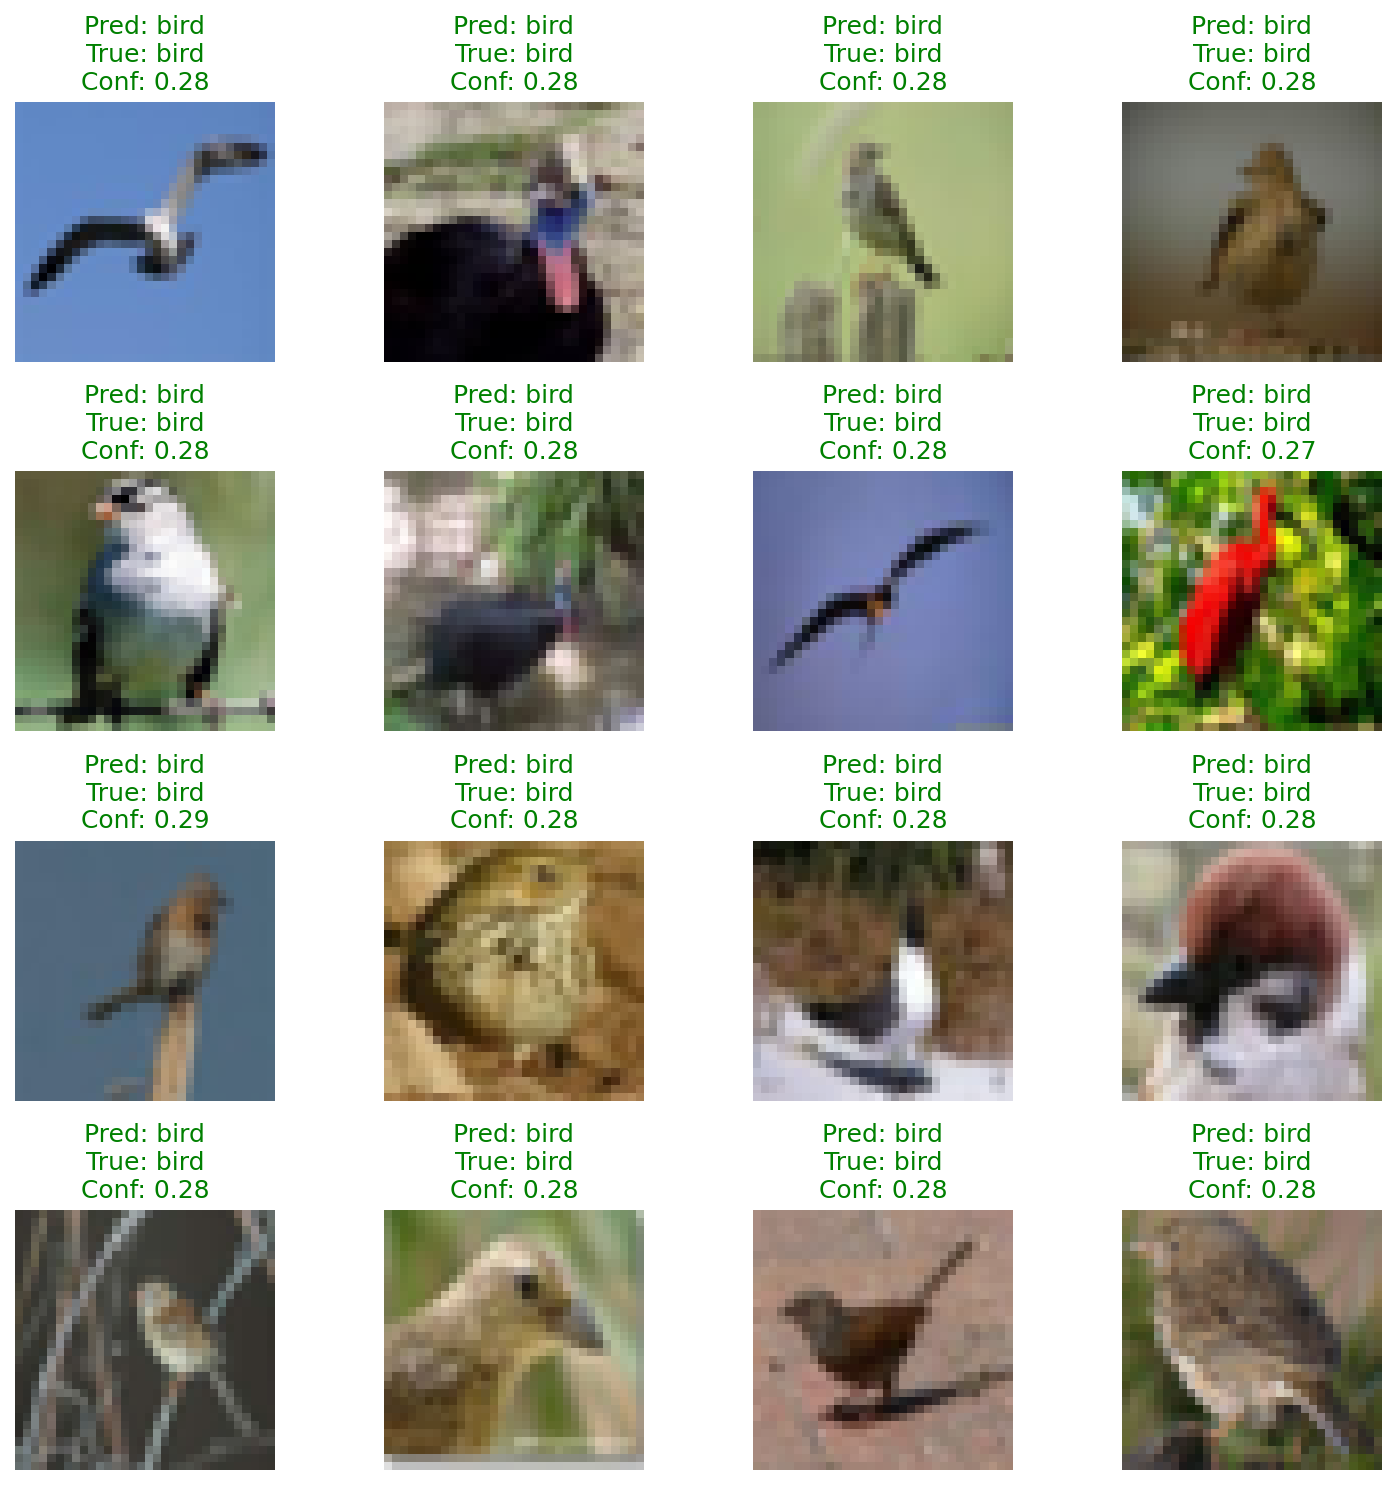

In [ ]:
# underconfident samples but correct
underconfident_correct = np.logical_and(preds == gts, confs.max(1) < 0.3)
plot_samples(
    images[underconfident_correct],
    labels[underconfident_correct],
    confs[underconfident_correct],
    preds[underconfident_correct],
)
